In [1]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


# Example: embeddings is a PyTorch tensor of shape (p+1, D)
# embeddings = torch.randn(p + 1, D)
def PCA_print(model):
  # 1. Remove the last column
  embeddings_reduced = model.embed.W_E.T[:-1, :]

  # 2. Normalize: subtract mean and divide by std for each feature
  mean = embeddings_reduced.mean(dim=0, keepdim=True)
  std = embeddings_reduced.std(dim=0, keepdim=True)
  embeddings_normalized = (embeddings_reduced - mean) / (std + 1e-8)  # add epsilon to avoid div by 0

  # 3. Convert to NumPy
  embeddings_np = embeddings_reduced.detach().cpu().numpy()

  # 4. Perform PCA
  pca = PCA(n_components=2)
  embeddings_2d = pca.fit_transform(embeddings_np)



  # 5. Plot with labels
  plt.figure(figsize=(8, 8))
  for i, (x, y) in enumerate(embeddings_2d):
      plt.scatter(x, y, color='blue')
      plt.text(x + 0.02, y + 0.02, str(i), fontsize=9)

  plt.title("2D PCA of Normalized Number Embeddings")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [2]:
# AUTOGENERATED! DO NOT EDIT! File to edit: ../transformer.ipynb.

# %% auto 0
__all__ = ['Config', 'HookPoint', 'Embed', 'Unembed', 'PosEmbed', 'LayerNorm', 'Attention', 'MLP', 'TransformerBlock',
           'Transformer', 'make_fourier_basis', 'calculate_key_freqs', 'get_components_of_trig_loss',
           'calculate_excluded_loss', 'calculate_trig_loss', 'calculate_coefficients', 'gen_train_test', 'full_loss',
           'Trainer', 'train_model']

# %% ../transformer.ipynb 3
import numpy as np
import torch as t
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F
import einops
import random
import helpers
from dataclasses import dataclass
import os
import wandb

# %% ../transformer.ipynb 4
# TODO does dataclass really require type annotations lol


@dataclass(frozen = True)
class Config():
    lr: float = 1e-3 #@param
    weight_decay: float = 0.3 #@param
    p: int = 12 #@param
    d_model: int = 512 #@param
    fn_name: str = 'slope' #@param ['add', 'subtract', 'x2xyy2','rand', 'slope']
    frac_train: float = 0.8 #@param
    num_epochs: int = 25000 #@param
    save_models: bool = False #@param
    save_every: int = 100 #@param

    # TODO for the first 1000 steps, save every 10 because 'interesting stuff happens at the start'
    # TODO add a helper function to generate indices here

    # Stop training when test loss is <stopping_thresh
    stopping_thresh: int = -1 #@param
    seed: int = 0 #@param

    num_layers: int = 1
    batch_style: str = 'full'
    d_vocab: int = p*p+1
    n_ctx: int = 3
    d_mlp: int = 4*d_model
    num_heads: int = 4

    act_type: str = 'ReLU' #@param ['ReLU', 'GeLU']


    device: t.device = t.device("cuda")

    # TODO ankify the privileged basis concept- a priori vs etc. ; consider writing up an explanation of privileged basis

    use_ln: bool = False

    take_metrics_every_n_epochs: int = 1000 #@param

    @property
    def d_head(self):
        return self.d_model // self.num_heads

    @property
    def random_answers(self):
        return np.random.randint(low=0, high=self.p, size=(self.p, self.p))

    @property
    def fns_dict(self):
        return {
            'add': lambda x, y: (x + y) % self.p,
            'subtract': lambda x, y: (x - y) % self.p,
            'x2xyy2': lambda x, y: (x**2 + x*y + y**2) % self.p,
            'rand': lambda x, y: self.random_answers[x][y],
            'slope': lambda x, y: round(abs(((y // self.p) - (x // self.p)) / ((y % self.p) - (x % self.p)))
)

        }


    @property
    def fn(self):
        return self.fns_dict[self.fn_name]

    def is_train_is_test(self, train):
        '''Creates an array of Boolean indices according to whether each data point is in train or test.
        Used to index into the big batch of all possible data'''
        # TODO probably the wrong place for this
        is_train = []
        is_test = []
        for x in range(self.p):
            for y in range(self.p):
                if (x, y, 113) in train:
                    is_train.append(True)
                    is_test.append(False)
                else:
                    is_train.append(False)
                    is_test.append(True)
        is_train = np.array(is_train)
        is_test = np.array(is_test)
        return (is_train, is_test)

    def is_it_time_to_save(self, epoch):
        return (epoch % self.save_every == 0)

    def is_it_time_to_take_metrics(self, epoch):
        return epoch % self.take_metrics_every_n_epochs == 0

# TODO make this an assert inside the consturctor
assert Config.d_model % Config.num_heads == 0

# %% ../transformer.ipynb 5
class HookPoint(nn.Module):
    '''A helper class to get access to intermediate activations (inspired by Garcon)
    It's a dummy module that is the identity function by default
    I can wrap any intermediate activation in a HookPoint and get a convenient way to add PyTorch hooks
    '''
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x

# %% ../transformer.ipynb 6
class Embed(nn.Module):
    '''Define network architecture
    I defined my own transformer from scratch so I'd fully understand each component
    - I expect this wasn't necessary or particularly important, and a bunch of this replicates existing Pyt functionality
    '''
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(t.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        #this Embeding needs to change!

        return t.einsum('dbp -> bpd', self.W_E[:, x])

#| export
class Unembed(nn.Module):
    def __init__(self, p, d_model):
        super().__init__()
        self.W_U = nn.Parameter(t.randn(d_model, p)/np.sqrt(p))

    def forward(self, x):
        return (x @ self.W_U)

#| export
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(t.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

#| export
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(t.ones(d_model))
        self.b_ln = nn.Parameter(t.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

#| export
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(t.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(t.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(t.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(t.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', t.tril(t.ones((n_ctx, n_ctx))) )
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(t.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(t.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(t.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = t.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = t.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(t.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = t.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

#| export
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(t.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(t.zeros(d_mlp))
        self.W_out = nn.Parameter(t.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(t.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = self.hook_pre(t.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = t.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# export
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

#| export
class Transformer(nn.Module):
    def __init__(self, config: Config, use_cache=False, use_ln=True):
        '''this function could be augmented to contain more options for creating different architectures'''
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache
        self.embed = Embed(d_vocab = config.d_vocab, d_model = config.d_model)
        self.pos_embed = PosEmbed(max_ctx = config.n_ctx, d_model = config.d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model = config.d_model,
            d_mlp = config.d_mlp,
            d_head = config.d_head,
            num_heads = config.num_heads,
            n_ctx = config.n_ctx,
            act_type = config.act_type,
            model=[self]) for i in range(config.num_layers)])
        self.unembed = Unembed(p = config.p, d_model = config.d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')

    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')







def calculate_excluded_loss(config: Config, fourier_basis, key_freqs, is_train, is_test, labels, logits):
    row = []
    for freq in key_freqs:
        cos = helpers.get_component_cos_xpy(logits, freq, fourier_basis=fourier_basis)
        sin = helpers.get_component_sin_xpy(logits, freq, fourier_basis=fourier_basis)
        value = helpers.test_logits(logits - cos - sin, bias_correction=False, mode='train', p = config.p,
           is_train = is_train, is_test = is_test, labels = labels)
        row.append(value.item())
    return row

In [3]:
# %% ../transformer.ipynb 8
# TODO move this into the config?
import dataclasses
from collections import defaultdict


def gen_train_test(config: Config):
    '''Generate train and test split'''
    num_to_generate = config.p
    grid_points = [(i, j) for i in range(num_to_generate) for j in range(num_to_generate)]
    #IMPORTAN
    #we imbed the points as vectors here imidiatelly baceuse it is simpler, imidiatiley flatten 2D gridn to 1D by index = y*p + x
    pairs = [(point1[0] * num_to_generate + point1[1], point2[0] * num_to_generate + point2[1], num_to_generate * num_to_generate ) for point1 in grid_points for point2 in grid_points if (point1[1] != point2[1] and point1[0] * num_to_generate + point1[1]> point2[0] * num_to_generate + point2[1])]
    random.seed(config.seed)
    random.shuffle(pairs)
    div = int(config.frac_train*len(pairs))
    return pairs[:div], pairs[div:]
"""

def gen_train_test(config: Config):
    '''Generate train and test split'''
    num_to_generate = config.p
    up_bound = 11 * (num_to_generate **2)//12
    low_bound = (num_to_generate **2)//12
    grid_points = [(i, j) for i in range(num_to_generate) for j in range(num_to_generate)]
    pairs = []
    #IMPORTAN
    #we imbed the points as vectors here imidiatelly baceuse it is simpler, imidiatiley flatten 2D gridn to 1D by index = y*p + x
    for point1 in grid_points:
        for point2 in grid_points:
          if point1[1] == point2[1] or (point1[0] * num_to_generate + point1[1] < low_bound and point2[0] * num_to_generate + point2[1] >= up_bound) or (point1[0] * num_to_generate + point1[1] >= up_bound and point2[0] * num_to_generate + point2[1] < low_bound):
            pass
          else:
            pairs.append((point1[0] * num_to_generate + point1[1], point2[0] * num_to_generate + point2[1], num_to_generate * num_to_generate ))
    random.seed(config.seed)
    random.shuffle(pairs)
    div = int(config.frac_train*len(pairs))
    return pairs[:div], pairs[div:]
"""



"\n\ndef gen_train_test(config: Config):\n    '''Generate train and test split'''\n    num_to_generate = config.p\n    up_bound = 11 * (num_to_generate **2)//12\n    low_bound = (num_to_generate **2)//12\n    grid_points = [(i, j) for i in range(num_to_generate) for j in range(num_to_generate)]\n    pairs = []\n    #IMPORTAN\n    #we imbed the points as vectors here imidiatelly baceuse it is simpler, imidiatiley flatten 2D gridn to 1D by index = y*p + x\n    for point1 in grid_points:\n        for point2 in grid_points:\n          if point1[1] == point2[1] or (point1[0] * num_to_generate + point1[1] < low_bound and point2[0] * num_to_generate + point2[1] >= up_bound) or (point1[0] * num_to_generate + point1[1] >= up_bound and point2[0] * num_to_generate + point2[1] < low_bound):\n            pass\n          else:\n            pairs.append((point1[0] * num_to_generate + point1[1], point2[0] * num_to_generate + point2[1], num_to_generate * num_to_generate ))\n    random.seed(config.seed)

In [4]:

# TODO what type for model?
def full_loss(config : Config, model: Transformer, data):
    '''Takes the cross entropy loss of the model on the data'''
    # Take the final position only
    logits = model(data)[:, -1]
    labels = t.tensor([config.fn(i, j) for i, j, _ in data]).to(config.device)
    #the function below should work if I get the labels right!
    return helpers.cross_entropy_high_precision(logits, labels)

In [5]:
def test_accuracy(config : Config, model: Transformer, data):
    '''Takes the cross entropy loss of the model on the data'''
    # Take the final position only
    logits = model(data)[:, -1]
    preds = logits.argmax(dim=-1)
    labels = t.tensor([config.fn(i, j) for i, j, _ in data]).to(config.device)

    acc = (preds == labels).float().mean().item()
    return acc * 100.0

In [6]:
config = Config()
a, b = gen_train_test(config)

labels = t.tensor([config.fn(i, j) for i, j, _ in a])

print(type(a[0]))

<class 'tuple'>


In [7]:
class Trainer:
    '''TODO
    ways this stinks:
    - callbacks every k epochs
    - training on infinite data
    - general abstract class w/o assumption and subclasses w/ more assumptions
    - check out hugging face trainer
    - disentangle optimization step and taking gradients
    - forward compatibility, e.g. batches per step
    '''

    def __init__(self, config : Config, model = None) -> None:
        wandb.init(project = "grokking", config = dataclasses.asdict(config))
        self.model = model if model is not None else Transformer(config, use_cache=False)
        self.model.to(config.device)
        self.optimizer = optim.AdamW(self.model.parameters(), lr = config.lr, weight_decay=config.weight_decay, betas=(0.9, 0.98))
        self.scheduler = optim.lr_scheduler.LambdaLR(self.optimizer, lambda step: min(step/10, 1)) # TODO make this a config option
        self.run_name = f"grok_{int(time.time())}"
        self.train, self.test = gen_train_test(config = config)
        self.metrics_dictionary = defaultdict(dict) # so we can safely call 'update' on keys
        print('training length = ', len(self.train))
        print('testing length = ', len(self.test))
        self.train_losses = []
        self.test_losses = []
        self.config = config

    def save_epoch(self, epoch, save_to_wandb = True):
        ''' precondition! train loss and test losses have been appended to '''
        save_dict = {
            'model': self.model.state_dict(),
            'train_loss': self.train_losses[-1],
            'test_loss': self.test_losses[-1],
            'epoch': epoch,
        }
        if save_to_wandb:
            wandb.log(save_dict)
            print("Saved epoch to wandb")
        if self.config.save_models:
            t.save(save_dict, helpers.root/self.run_name/f"{epoch}.pth")
            print(f"Saved model to {helpers.root/self.run_name/f'{epoch}.pth'}")
        self.metrics_dictionary[epoch].update(save_dict)

    def do_a_training_step(self, epoch: int):
        '''returns train_loss, test_loss'''
        train_loss = full_loss(config = self.config, model = self.model, data = self.train)
        test_loss = full_loss(config = self.config, model = self.model, data = self.test)
        self.train_losses.append(train_loss.item())
        self.test_losses.append(test_loss.item())
        if epoch % 200 == 0:
            # TODO is this ok? this was np.log, and it was barking at me ; i think np.log was being interpreted as a logging module
            accuracy = test_accuracy(config = self.config, model = self.model, data = self.test)
            print(f'Epoch {epoch}, train loss {t.log(train_loss).item():.4f}, test loss {t.log(test_loss).item():.4f}')
            print(f'test accuracy {accuracy:.4f}')
        train_loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        self.optimizer.zero_grad()
        return train_loss, test_loss

    def initial_save_if_appropriate(self):
        if self.config.save_models:
            os.mkdir(helpers.root/self.run_name)
            save_dict = {
                'model': self.model.state_dict(),
                'train_data' : self.train,
                'test_data' : self.test}
            t.save(save_dict, helpers.root/self.run_name/'init.pth')


    def post_training_save(self, save_optimizer_and_scheduler = True, log_to_wandb = True):
        if not self.config.save_models:
            os.makedirs(helpers.root/self.run_name, exist_ok=True)
        save_dict = {
            'model': self.model.state_dict(),
            'train_loss': self.train_losses[-1],
            'test_loss': self.test_losses[-1],
            'train_losses': self.train_losses,
            'test_losses': self.test_losses,
            'epoch': self.config.num_epochs,
        }
        if save_optimizer_and_scheduler:
            save_dict['optimizer'] = self.optimizer.state_dict()
            save_dict['scheduler'] = self.scheduler.state_dict()
        if log_to_wandb:
            wandb.log(save_dict)
        t.save(save_dict, helpers.root/self.run_name/f"final.pth")
        print(f"Saved model to {helpers.root/self.run_name/f'final.pth'}")
        self.metrics_dictionary[save_dict['epoch']].update(save_dict)



def train_model(config: Config):
    world = Trainer(config = config)
    print(f'Run name {world.run_name}')
    world.initial_save_if_appropriate()

    for epoch in range(config.num_epochs):
        train_loss, test_loss = world.do_a_training_step(epoch)
        if test_loss.item() < config.stopping_thresh:
            break
        if config.is_it_time_to_save(epoch = epoch):
            # TODO this also used to do a check about test loss- pretty sure not necessary
            world.save_epoch(epoch = epoch)
        if config.is_it_time_to_take_metrics(epoch = epoch):
            pass
            #world.take_metrics(epoch = epoch, train = world.train)

    world.post_training_save(save_optimizer_and_scheduler=True)
    helpers.lines([world.train_losses, world.test_losses], labels=['train', 'test'], log_y=True)
    return world # to export the dictionary with the training metrics

In [8]:
config = Config()
model = train_model(config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: am3078 (am3078-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


training length =  7603
testing length =  1901
Run name grok_1753782903
Epoch 0, train loss 1.1804, test loss 1.1816
test accuracy 1.9989
Saved epoch to wandb
Saved epoch to wandb
Epoch 200, train loss -6.0456, test loss -0.0573
test accuracy 75.5918
Saved epoch to wandb
Saved epoch to wandb
Epoch 400, train loss -8.6615, test loss 0.0559
test accuracy 77.4329
Saved epoch to wandb
Saved epoch to wandb
Epoch 600, train loss -10.9545, test loss 0.1376
test accuracy 78.4324
Saved epoch to wandb
Saved epoch to wandb
Epoch 800, train loss -13.1022, test loss 0.1873
test accuracy 80.2735
Saved epoch to wandb
Saved epoch to wandb
Epoch 1000, train loss -15.0039, test loss 0.1926
test accuracy 82.1673
Saved epoch to wandb
Saved epoch to wandb
Epoch 1200, train loss -16.2879, test loss 0.1755
test accuracy 83.6928
Saved epoch to wandb
Saved epoch to wandb
Epoch 1400, train loss -16.9243, test loss 0.1572
test accuracy 84.0610
Saved epoch to wandb
Saved epoch to wandb
Epoch 1600, train loss -17.

In [9]:
result_intermediate = model.model(t.tensor([[61, 44,144]]))
print(result_intermediate[:, -1].argmax(dim=-1).item())
#result = result_intermediate[:, -1, :-1]

0


In [10]:
number = 0
total = 0
for x in range(144):
  for y in range(x):
      #print(result[:, -1])
      if x%12 !=y%12:
        total += 1
        result = model.model(t.tensor([[x, y, 144]]))[:,-1]
        if config.fn(x,y) != result.argmax(dim=-1).item():
          #print(x, y, config.fn(x,y), result.argmax(dim=-1).item())
          number += 1
print((1- 2*number/total)*100)


100.0


In [11]:
result_intermediate = model.model(t.tensor([[54, 122,144], [122,54,144]]))
print(result_intermediate[:, -1])

tensor([[  22.9097,  -24.8450,  -81.7787,  -80.4223,  -47.0923,  -74.3436,
          -53.7697, -100.8648, -101.1970,  -70.4997,  -92.1277,  -42.5980],
        [ -64.1713,  -52.5967,  -39.6861,  -55.4276,  -61.6479,  -68.1367,
          -74.5293,  -79.5434,  -84.9388,  -80.7622,  -96.1771,  -94.9411]],
       device='cuda:0', grad_fn=<SelectBackward0>)


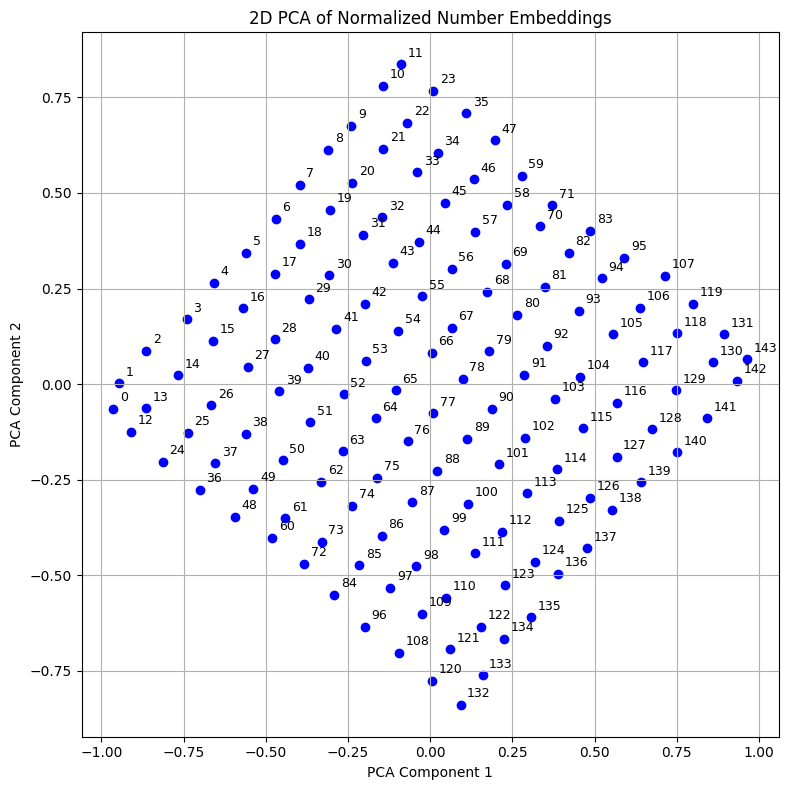

In [12]:
PCA_print(model.model)